In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from datetime import datetime
from scipy.stats import moment
from copy import deepcopy
from tqdm import tqdm
import pickle

import sys
from os.path import dirname, abspath
import os
sys.path.append(dirname(dirname(abspath('__file__')))+'/utils')

from keras.layers import Dense, LeakyReLU, Activation, Dropout

from keras.models import Sequential, load_model
from keras.utils import to_categorical
from keras import optimizers
import keras
import tensorflow as tf

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

from check_performance import checkPerformance
from line_suppression import seg_line_sup

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [42]:
features_filtered_split_filename = "features_filtered_split_30_10.pkl"
output_y_segm_split_filename = "output_y_segm_split_30_10.pkl"
indices_split_filename = "indices_split.pkl"
simple_features_split_filename = "simple_features_split_30_10.pkl"

# features_filtered_real_filename = "features_filtered_real_30_10.pkl"
# output_y_segm_real_filename = "output_y_segm_real_30_10.pkl"
# indices_real_filename = "indices_real_30_10.pkl"
# simple_features_real_filename = "simple_features_real_30_10.pkl"

features_filtered_real_filename = "features_filtered_real_30_10_ah.pkl"
output_y_segm_real_filename = "output_y_segm_real_30_10_ah.pkl"
indices_real_filename = "indices_real_30_10_ah.pkl"
simple_features_real_filename = "simple_features_real_30_10_ah.pkl"

In [43]:
with open(features_filtered_split_filename, "rb") as file:
    X_load = pickle.load(file)
    
with open(output_y_segm_split_filename, "rb") as file:
    y_load = pickle.load(file)
    
with open(indices_split_filename, "rb") as file:
    idx_load = pickle.load(file)
    
with open(simple_features_split_filename, "rb") as file:
    sf_load = pickle.load(file)    

X_train = X_load["train"].copy()
X_test = X_load["test"].copy()
X_val = X_load["val"].copy()

y_train = np.reshape(y_load["train"], -1).astype(int)
y_test = np.reshape(y_load["test"], -1).astype(int)
y_val = np.reshape(y_load["val"], -1).astype(int)

idx_train = idx_load["train"]
idx_test = idx_load["test"]
idx_val = idx_load["val"]

sf_train = sf_load["train"].copy()
sf_test = sf_load["test"].copy()
sf_val = sf_load["val"].copy()

In [44]:
with open(features_filtered_real_filename, "rb") as file:
    X_load_real = pickle.load(file)
    
with open(output_y_segm_real_filename, "rb") as file:
    y_load_real = pickle.load(file)
    
with open(indices_real_filename, "rb") as file:
    idx_load_real = pickle.load(file)
    
with open(simple_features_real_filename, "rb") as file:
    sf_load_real = pickle.load(file)    

X_real = X_load_real.copy()
y_real = np.reshape(y_load_real, -1).astype(int)
idx_real = idx_load_real
sf_real = sf_load_real.copy()

In [24]:
X_load["train"]

value__variance_larger_than_standard_deviation  \
0                                                  1.0   
1                                                  1.0   
2                                                  1.0   
3                                                  1.0   
4                                                  1.0   
...                                                ...   
195995                                             1.0   
195996                                             1.0   
195997                                             1.0   
195998                                             1.0   
195999                                             1.0   

        value__has_duplicate_max  value__has_duplicate_min  \
0                            0.0                       0.0   
1                            0.0                       0.0   
2                            0.0                       0.0   
3                            0.0                       0.0   
4                            0.0                       0.0   
...                          ...                       ...   
195995                       0.0                       0.0   
195996                       0.0                       0.0   
195997                       0.0                       0.0   
195998                       0.0                       0.0   
195999                       1.0                       0.0   

        value__has_duplicate  value__sum_values  value__abs_energy  \
0                        0.0        -142.494096        1357.666091   
1                        0.0        -100.802112        1076.690886   
2                        0.0        -106.725089        1281.241685   
3                        0.0         -69.304706        1293.637227   
4                        0.0         -61.097341        1139.641288   
...                      ...                ...                ...   
195995                   0.0       -1211.889415       49662.456623   
195996                   0.0       -1254.489188       53170.275879   
195997                   0.0       -1275.906223       55170.179779   
195998                   0.0       -1309.883373       57515.896764   
195999                   1.0       -1205.719635       54216.473019   

        value__mean_abs_change  value__mean_change  \
0                     4.665741            0.204594   
1                     4.156360            0.544758   
2                     5.114116           -0.278268   
3                     6.433016           -0.316075   
4                     5.367640            0.187704   
...                        ...                 ...   
195995                3.882957           -0.159652   
195996                3.735647           -0.215172   
195997                4.060348           -0.824092   
195998                2.790359           -0.181324   
195999                4.316434            1.505405   

        value__mean_second_derivative_central  value__median  ...  \
0                                    0.306088      -5.065412  ...   
1                                    0.180299      -4.334624  ...   
2                                    0.010936      -4.200799  ...   
3                                   -0.064521      -1.788650  ...   
4                                    0.217288      -1.564844  ...   
...                                       ...            ...  ...   
195995                               0.044974     -40.592790  ...   
195996                              -0.025681     -41.978231  ...   
195997                               0.342800     -43.137476  ...   
195998                              -0.054789     -43.818624  ...   
195999                              -0.027385     -44.750594  ...   

        value__fft_coefficient__attr_"real"__coeff_7  \
0                                         -40.993545   
1                                          12.805131   
2                                          10.333086   
3                      

In [45]:
from sklearn.preprocessing import MinMaxScaler

scaler_pos = MinMaxScaler()
scaler_neg = MinMaxScaler()

scaler_pos_sf = MinMaxScaler()
scaler_neg_sf = MinMaxScaler()

cols_to_ignore = ["value__sample_entropy", "label", "ts_id", "win_id"]

cols_neg_sf = sf_train.columns[sf_train.apply(np.min) < 0]
cols_pos_sf = sf_train.columns[sf_train.apply(np.min) >= 0]
cols_pos_sf = [col for col in cols_pos_sf if col not in cols_to_ignore]

cols_neg = X_train.columns[X_train.apply(np.min) < 0]
cols_pos = X_train.columns[X_train.apply(np.min) >= 0]
cols_pos = [col for col in cols_pos if col not in cols_to_ignore]

scaler_pos.fit(X_train[cols_pos])
scaler_neg.fit(X_train[cols_neg])

X_train[cols_pos] = scaler_pos.transform(X_train[cols_pos])
X_train[cols_neg] = scaler_neg.transform(X_train[cols_neg])

X_test[cols_pos] = scaler_pos.transform(X_test[cols_pos])
X_test[cols_neg] = scaler_neg.transform(X_test[cols_neg])

X_val[cols_pos] = scaler_pos.transform(X_val[cols_pos])
X_val[cols_neg] = scaler_neg.transform(X_val[cols_neg])


scaler_pos_sf.fit(sf_train[cols_pos_sf])
scaler_neg_sf.fit(sf_train[cols_neg_sf])

sf_train[cols_pos_sf] = scaler_pos_sf.transform(sf_train[cols_pos_sf])
sf_train[cols_neg_sf] = scaler_neg_sf.transform(sf_train[cols_neg_sf])

sf_test[cols_pos_sf] = scaler_pos_sf.transform(sf_test[cols_pos_sf])
sf_test[cols_neg_sf] = scaler_neg_sf.transform(sf_test[cols_neg_sf])

sf_val[cols_pos_sf] = scaler_pos_sf.transform(sf_val[cols_pos_sf])
sf_val[cols_neg_sf] = scaler_neg_sf.transform(sf_val[cols_neg_sf])

X_real[cols_pos] = scaler_pos.transform(X_real[cols_pos])
X_real[cols_neg] = scaler_neg.transform(X_real[cols_neg])
sf_real[cols_pos_sf] = scaler_pos_sf.transform(sf_real[cols_pos_sf])
sf_real[cols_neg_sf] = scaler_neg_sf.transform(sf_real[cols_neg_sf])

In [46]:
X_train = pd.concat([X_train, pd.DataFrame(idx_train, columns=["ts_id", "win_id"]), pd.DataFrame(y_train, columns=["label"])], axis=1)
X_test = pd.concat([X_test, pd.DataFrame(idx_test, columns=["ts_id", "win_id"]), pd.DataFrame(y_test, columns=["label"])], axis=1)
X_val = pd.concat([X_val, pd.DataFrame(idx_val, columns=["ts_id", "win_id"]), pd.DataFrame(y_val, columns=["label"])], axis=1)

sf_train = pd.concat([sf_train, pd.DataFrame(idx_train, columns=["ts_id", "win_id"])], axis=1)
sf_test = pd.concat([sf_test, pd.DataFrame(idx_test, columns=["ts_id", "win_id"])], axis=1)
sf_val = pd.concat([sf_val, pd.DataFrame(idx_val, columns=["ts_id", "win_id"])], axis=1)

X_real = pd.concat([X_real, pd.DataFrame(idx_real, columns=["ts_id", "win_id"]), pd.DataFrame(y_real, columns=["label"])], axis=1)
sf_real = pd.concat([sf_real, pd.DataFrame(idx_real, columns=["ts_id", "win_id"])], axis=1)


In [27]:
X_train

value__variance_larger_than_standard_deviation  \
0                                                  1.0   
1                                                  1.0   
2                                                  1.0   
3                                                  1.0   
4                                                  1.0   
...                                                ...   
195995                                             1.0   
195996                                             1.0   
195997                                             1.0   
195998                                             1.0   
195999                                             1.0   

        value__has_duplicate_max  value__has_duplicate_min  \
0                            0.0                       0.0   
1                            0.0                       0.0   
2                            0.0                       0.0   
3                            0.0                       0.0   
4                            0.0                       0.0   
...                          ...                       ...   
195995                       0.0                       0.0   
195996                       0.0                       0.0   
195997                       0.0                       0.0   
195998                       0.0                       0.0   
195999                       1.0                       0.0   

        value__has_duplicate  value__sum_values  value__abs_energy  \
0                        0.0           0.618588           0.003513   
1                        0.0           0.626549           0.002777   
2                        0.0           0.625418           0.003313   
3                        0.0           0.632563           0.003346   
4                        0.0           0.634130           0.002942   
...                      ...                ...                ...   
195995                   0.0           0.414389           0.130016   
195996                   0.0           0.406254           0.139202   
195997                   0.0           0.402165           0.144440   
195998                   0.0           0.395677           0.150583   
195999                   1.0           0.415567           0.141942   

        value__mean_abs_change  value__mean_change  \
0                     0.379260            0.384927   
1                     0.331747            0.441838   
2                     0.421082            0.304143   
3                     0.544104            0.297817   
4                     0.444730            0.382101   
...                        ...                 ...   
195995                0.306245            0.323987   
195996                0.292504            0.314699   
195997                0.322791            0.212824   
195998                0.204332            0.320362   
195999                0.346678            0.602557   

        value__mean_second_derivative_central  value__median  ...  \
0                                    0.698912       0.610865  ...   
1                                    0.634045       0.614890  ...   
2                                    0.546708       0.615628  ...   
3                                    0.507797       0.628914  ...   
4                                    0.653119       0.630146  ...   
...                                       ...            ...  ...   
195995                               0.564261       0.415181  ...   
195996                               0.527826       0.407550  ...   
195997                               0.717843       0.401165  ...   
195998                               0.512815       0.397413  ...   
195999                               0.526947       0.392280  ...   

        value__fft_coefficient__attr_"real"__coeff_12  \
0                                            0.431500   
1                                            0.263263   
2                                            0.371154   
3                  

In [143]:
X_real

value__variance_larger_than_standard_deviation  \
0                                                1.0   
1                                                1.0   
2                                                1.0   
3                                                1.0   
4                                                1.0   
...                                              ...   
2067                                             1.0   
2068                                             1.0   
2069                                             1.0   
2070                                             1.0   
2071                                             1.0   

      value__has_duplicate_max  value__has_duplicate_min  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          1.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
2067                       0.0                       0.0   
2068                       0.0                       0.0   
2069                       0.0                       0.0   
2070                       0.0                       0.0   
2071                       1.0                       0.0   

      value__has_duplicate  value__sum_values  value__abs_energy  \
0                      1.0           0.637376           0.000646   
1                      1.0           0.630597           0.001760   
2                      1.0           0.627962           0.001583   
3                      1.0           0.626625           0.001664   
4                      1.0           0.625117           0.001947   
...                    ...                ...                ...   
2067                   1.0           0.584999           0.009450   
2068                   1.0           0.582497           0.010419   
2069                   0.0           0.579156           0.011473   
2070                   1.0           0.574458           0.013075   
2071                   1.0           0.584369           0.010832   

      value__mean_abs_change  value__mean_change  \
0                   0.198155            0.335698   
1                   0.249296            0.352429   
2                   0.158272            0.350698   
3                   0.154734            0.348967   
4                   0.172746            0.320122   
...                      ...                 ...   
2067                0.074002            0.339160   
2068                0.106809            0.347236   
2069                0.127716            0.331660   
2070                0.199442            0.370313   
2071                0.202015            0.434926   

      value__mean_second_derivative_central  value__median  ...  \
0                                  0.554882       0.628851  ...   
1                                  0.573299       0.628300  ...   
2                                  0.506997       0.623894  ...   
3                                  0.520810       0.622792  ...   
4                                  0.565932       0.622792  ...   
...                                     ...            ...  ...   
2067                               0.543831       0.575699  ...   
2068                               0.544752       0.575699  ...   
2069                               0.479372       0.569640  ...   
2070                               0.583428       0.569089  ...   
2071                               0.502393       0.580105  ...   

      value__fft_coefficient__attr_"real"__coeff_12  \
0                                          0.351407   
1                                          0.329722   
2                                          0.374262   
3                                          0.431324   
4                                          0.504025   
...                                

In [29]:
sf_train

mean    median       var  moment_3  moment_4   mean_fh  median_fh  \
0       0.618588  0.610865  0.018467  0.145122  0.000124  0.616448   0.614073   
1       0.626549  0.614890  0.020041  0.145433  0.000110  0.608583   0.609494   
2       0.625418  0.615628  0.024545  0.145095  0.000166  0.632979   0.623834   
3       0.632563  0.628914  0.030933  0.145170  0.000308  0.631505   0.633635   
4       0.634130  0.630146  0.027675  0.144865  0.000287  0.619402   0.621698   
...          ...       ...       ...       ...       ...       ...        ...   
195995  0.414389  0.415181  0.019176  0.145231  0.000546  0.421814   0.421322   
195996  0.406254  0.407550  0.019330  0.145883  0.000581  0.415258   0.413398   
195997  0.402165  0.401165  0.024657  0.146920  0.000728  0.408427   0.407400   
195998  0.395677  0.397413  0.008606  0.145851  0.000157  0.400020   0.400140   
195999  0.415567  0.392280  0.158273  0.193950  0.022279  0.400722   0.394840   

          var_fh  moment_3_fh  moment_4_fh  ...  moment_3_d2_fh  \
0       0.125239     0.445906     0.005668  ...        0.569423   
1       0.031635     0.447369     0.000330  ...        0.556848   
2       0.094684     0.449957     0.003093  ...        0.557873   
3       0.140852     0.443452     0.006285  ...        0.552157   
4       0.182446     0.466270     0.020358  ...        0.525894   
...          ...          ...          ...  ...             ...   
195995  0.010087     0.447839     0.000050  ...        0.555263   
195996  0.171612     0.455718     0.037652  ...        0.541243   
195997  0.169420     0.467701     0.040139  ...        0.575804   
195998  0.005920     0.447654     0.000016  ...        0.555826   
195999  0.071038     0.464826     0.009758  ...        0.536965   

        moment_4_d2_fh  mean_d2_sh  median_d2_sh  var_d2_sh  moment_3_d2_sh  \
0             0.006229    0.609147      0.525231   0.012991        0.609634   
1             0.000304    0.601954      0.521371   0.047333        0.606051   
2             0.001262    0.431775      0.321339   0.063468        0.606511   
3             0.005953    0.463482      0.429732   0.076642        0.581731   
4             0.019611    0.553508      0.410740   0.017356        0.611254   
...                ...         ...           ...        ...             ...   
195995        0.000062    0.494018      0.386647   0.114825        0.596277   
195996        0.027164    0.486678      0.394924   0.002434        0.609433   
195997        0.007462    0.530209      0.422136   0.052253        0.589566   
195998        0.000015    0.500250      0.526555   0.054936        0.590348   
195999        0.009870    0.500785      0.467159   0.135755        0.606889   

        moment_4_d2_sh  label  ts_id  win_id  
0             0.000067      0   6084       0  
1             0.000826      0   6084       1  
2             0.001446      0   6084       2  
3             0.004895      0   6084       3  
4             0.000133      0   6084       4  
...                ...    ...    ...     ...  
195995        0.008020      0   2036      23  
195996        0.000003      0   2036      24  
195997        0.002980      0   2036      25  
195998        0.002927      0   2036      26  
195999        0.021412      0   2036      27  

[196000 rows x 48 columns]

In [30]:
sf_real

mean    median       var  moment_3  moment_4   mean_fh  median_fh  \
0     0.616161  0.609849  0.005738  0.144864  0.000019  0.613346   0.617061   
1     0.621145  0.612603  0.003528  0.144975  0.000007  0.617236   0.616501   
2     0.620267  0.611776  0.002770  0.145010  0.000004  0.620811   0.616781   
3     0.622405  0.612327  0.003674  0.145020  0.000006  0.620881   0.617620   
4     0.619751  0.611776  0.003175  0.144987  0.000006  0.617096   0.616221   
...        ...       ...       ...       ...       ...       ...        ...   
2263  0.512878  0.509603  0.002294  0.144995  0.000002  0.510578   0.509884   
2264  0.514062  0.510429  0.002757  0.144996  0.000003  0.513136   0.511003   
2265  0.509822  0.508777  0.003866  0.144976  0.000006  0.517237   0.516880   
2266  0.503941  0.499689  0.003793  0.145004  0.000006  0.507844   0.509604   
2267  0.516467  0.501066  0.049541  0.153490  0.002221  0.499887   0.500089   

        var_fh  moment_3_fh  moment_4_fh  ...  moment_3_d2_fh  moment_4_d2_fh  \
0     0.051972     0.445765     0.001221  ...        0.555950        0.000820   
1     0.018735     0.447179     0.000300  ...        0.556088        0.000640   
2     0.015533     0.448251     0.000123  ...        0.555149        0.000094   
3     0.015801     0.448184     0.000126  ...        0.555253        0.000115   
4     0.012415     0.447579     0.000099  ...        0.556009        0.000107   
...        ...          ...          ...  ...             ...             ...   
2263  0.004213     0.447665     0.000007  ...        0.555694        0.000008   
2264  0.014385     0.447774     0.000092  ...        0.555995        0.000434   
2265  0.014977     0.447669     0.000085  ...        0.556153        0.000105   
2266  0.022898     0.447631     0.000283  ...        0.555690        0.000164   
2267  0.018596     0.447892     0.000163  ...        0.554377        0.000310   

      mean_d2_sh  median_d2_sh  var_d2_sh  moment_3_d2_sh  moment_4_d2_sh  \
0       0.466747      0.408209   0.002615        0.609309        0.000003   
1       0.512011      0.441774   0.007717        0.608748        0.000033   
2       0.523747      0.438417   0.008207        0.609704        0.000036   
3       0.551408      0.441774   0.006841        0.609577        0.000033   
4       0.445791      0.441774   0.004215        0.609146        0.000011   
...          ...           ...        ...             ...             ...   
2263    0.509497      0.441774   0.016567        0.609406        0.000127   
2264    0.497761      0.445130   0.005802        0.609666        0.000022   
2265    0.502791      0.448487   0.008240        0.609156        0.000036   
2266    0.476806      0.451843   0.010001        0.608312        0.000055   
2267    0.511173      0.441774   0.034722        0.610238        0.001427   

      label  ts_id  win_id  
0         1     14       0  
1         0     14       1  
2         0     14       2  
3         0     14       3  
4         0     14       4  
...     ...    ...     ...  
2263      0   8122      23  
2264      0   8122      24  
2265      0   8122      25  
2266      0   8122      26  
2267      0   8122      27  

[2268 rows x 48 columns]

In [47]:
df = X_train.copy(deep=True)
print("printing column name where infinity is present")
col_name = df.columns.to_series()[np.isinf(df).any()]
print(col_name)

printing column name where infinity is present
value__sample_entropy    value__sample_entropy
dtype: object


In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{datetime.now().strftime('%Y%m%d-%H%M%S')}/")
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=30,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [55]:
model = Sequential()
model.add(Dense(units=128, input_shape=(242,)))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

sgd = optimizers.SGD(lr=0.001, decay=0.0, momentum=0.0, nesterov=False)
adam = optimizers.Adam(lr = 0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [211]:
model = Sequential()
model.add(Dense(units=256, input_shape=(242,)))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(units=192))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(units=160))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(units=128))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(units=32))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(1, activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0002,
    decay_steps=10000,
    decay_rate=0.9)
adam = optimizers.Adam(learning_rate = lr_schedule)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
X_train_ones = X_train[X_train["label"] == 1]
X_train_zeros = X_train[X_train["label"] == 0].sample(n=len(X_train_ones), random_state=133)
X_train_balanced = pd.concat([X_train_zeros, X_train_ones])
y_train_balanced = X_train_balanced["label"]

In [49]:
X_train_inp = X_train_balanced.drop(columns=["value__sample_entropy", "ts_id", "win_id", "label"])
X_test_inp = X_test.drop(columns=["value__sample_entropy", "ts_id", "win_id", "label"])
X_val_inp = X_val.drop(columns=["value__sample_entropy", "ts_id", "win_id", "label"])

X_real_inp = X_real.drop(columns=["value__sample_entropy", "ts_id", "win_id", "label"])

In [214]:
model_train = model.fit(X_train_inp, y_train_balanced, 
                        batch_size=32, 
                        validation_split=0.2, 
                        epochs=100, 
                        callbacks=[tensorboard_callback, early_stopping_monitor],
                       )

Epoch 1/100
1314/1314 [==============================] - 3s 2ms/step - loss: 0.6440 - accuracy: 0.6484 - val_loss: 0.7766 - val_accuracy: 0.3328
Epoch 2/100
1314/1314 [==============================] - 3s 2ms/step - loss: 0.6008 - accuracy: 0.6957 - val_loss: 0.8729 - val_accuracy: 0.2910
Epoch 3/100
1314/1314 [==============================] - 2s 2ms/step - loss: 0.5892 - accuracy: 0.7039 - val_loss: 0.8254 - val_accuracy: 0.3310
Epoch 4/100
1314/1314 [==============================] - 2s 2ms/step - loss: 0.5817 - accuracy: 0.7083 - val_loss: 0.8143 - val_accuracy: 0.3552
Epoch 5/100
1314/1314 [==============================] - 3s 2ms/step - loss: 0.5772 - accuracy: 0.7098 - val_loss: 0.8315 - val_accuracy: 0.3160
Epoch 6/100
1314/1314 [==============================] - 3s 2ms/step - loss: 0.5714 - accuracy: 0.7157 - val_loss: 0.7696 - val_accuracy: 0.4130
Epoch 7/100
1314/1314 [==============================] - 2s 2ms/step - loss: 0.5668 - accuracy: 0.7176 - val_loss: 0.8426 - val_ac

In [10]:
model = keras.models.load_model("subs_fcn_model_best2")

In [215]:
score = model.evaluate(X_test_inp, y_test, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

1750/1750 [==============================] - 1s 820us/step - loss: 0.5160 - accuracy: 0.8050
Test loss: 0.5159773230552673 / Test accuracy: 0.8050178289413452


In [216]:
np.sum(y_test)

8836

recall: 0.48378191856452724
precision: 0.4726904922454484
f1-score: 0.47817189631650747
[[42614  4692]
 [ 4488  4206]]


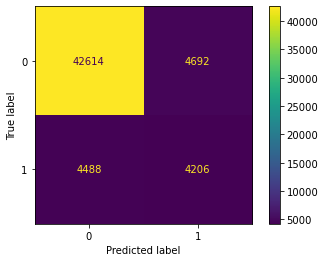

In [11]:
y_val_pred = (model.predict(X_val_inp) > 0.5).astype(int)

# Print f1, precision, and recall scores
print("recall:", recall_score(y_val, y_val_pred))
print("precision:", precision_score(y_val, y_val_pred))
print("f1-score:", f1_score(y_val, y_val_pred))

print(confusion_matrix(y_val, y_val_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred))
disp.plot()

recall: 0.498971898560658
precision: 0.46826758147512865
f1-score: 0.4831323968587546
[[21143  2480]
 [ 2193  2184]]


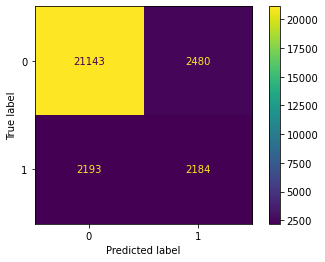

In [12]:
y_test_pred = (model.predict(X_test_inp) > 0.5).astype(int)

# Print f1, precision, and recall scores
print("recall:", recall_score(y_test, y_test_pred))
print("precision:", precision_score(y_test, y_test_pred))
print("f1-score:", f1_score(y_test, y_test_pred))

print(confusion_matrix(y_test, y_test_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred))
disp.plot()

In [136]:
X_real_inp

value__variance_larger_than_standard_deviation  \
0                                                1.0   
1                                                1.0   
2                                                1.0   
3                                                1.0   
4                                                1.0   
...                                              ...   
2263                                             1.0   
2264                                             1.0   
2265                                             1.0   
2266                                             1.0   
2267                                             1.0   

      value__has_duplicate_max  value__has_duplicate_min  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
2263                       0.0                       0.0   
2264                       0.0                       0.0   
2265                       0.0                       0.0   
2266                       0.0                       0.0   
2267                       1.0                       0.0   

      value__has_duplicate  value__sum_values  value__abs_energy  \
0                      1.0           0.616161           0.002633   
1                      1.0           0.621145           0.001775   
2                      1.0           0.620267           0.001808   
3                      1.0           0.622405           0.001644   
4                      1.0           0.619751           0.001910   
...                    ...                ...                ...   
2263                   1.0           0.512878           0.042502   
2264                   1.0           0.514062           0.041796   
2265                   1.0           0.509822           0.044618   
2266                   1.0           0.503941           0.048523   
2267                   1.0           0.516467           0.044741   

      value__mean_abs_change  value__mean_change  \
0                   0.172102            0.317814   
1                   0.152804            0.355890   
2                   0.142511            0.346659   
3                   0.147014            0.351275   
4                   0.106809            0.316083   
...                      ...                 ...   
2263                0.133827            0.366851   
2264                0.165026            0.342044   
2265                0.145728            0.340890   
2266                0.157628            0.314930   
2267                0.195260            0.490887   

      value__mean_second_derivative_central  value__median  ...  \
0                                  0.592637       0.609849  ...   
1                                  0.572378       0.612603  ...   
2                                  0.527256       0.611776  ...   
3                                  0.513443       0.612327  ...   
4                                  0.495947       0.611776  ...   
...                                     ...            ...  ...   
2263                               0.542911       0.509603  ...   
2264                               0.506997       0.510429  ...   
2265                               0.518048       0.508777  ...   
2266                               0.596320       0.499689  ...   
2267                               0.555802       0.501066  ...   

      value__fft_coefficient__attr_"real"__coeff_7  \
0                                         0.682080   
1                                         0.704410   
2                                         0.601287   
3                                         0.654993   
4                                         0.707492   
...                                      

recall: 0.6873385012919897
precision: 0.17250324254215305
f1-score: 0.27579056505961635
[[ 605 1276]
 [ 121  266]]


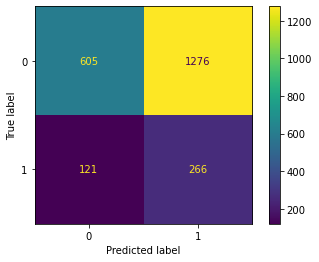

In [13]:
y_real_pred = (model.predict(X_real_inp) > 0.5).astype(int)

# Print f1, precision, and recall scores
print("recall:", recall_score(y_real, y_real_pred))
print("precision:", precision_score(y_real, y_real_pred))
print("f1-score:", f1_score(y_real, y_real_pred))

print(confusion_matrix(y_real, y_real_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_real, y_real_pred))
disp.plot()

In [10]:
def NaiveApproach(data_sample):

    out = []
    sign = []
    indices = range(data_sample.shape[0])
    
    # 3 samples, mean    
    for i in range(4,data_sample.shape[0]-4):
        yn = data_sample
        ma = np.mean([yn[i-3], yn[i-2], yn[i-1]]) 
        mb = np.mean([yn[i+1], yn[i+2], yn[i+3]]) 
        thres = np.mean([(ma), (mb)]) + 0.75*18.1
        thres2 = np.mean([(ma), (mb)]) - 0.75*18.1
        o = (yn[i] > thres or  yn[i] < thres2 )
        out.append(o)
        if o and i in indices:
            if yn[i] >= thres:
                s = 1
            else:
                s = -1
            sign.append(s)
    
    results_tmp = np.where(out)[0] + 4
    results_naive = []
    for j in list(results_tmp):
        if j in indices:
            results_naive.append(j)
    
    return (results_naive, sign)

def correct_ts(data_sample):
    new_data_sample = data_sample.copy()
    result_idxs, signs = NaiveApproach(data_sample)
    res = zip(result_idxs, signs)
    for idx, sign in res:
        new_data_sample[idx] += -1 * sign * 18.1 
    return new_data_sample

In [18]:
## Input the filenames and parameters:
filename = 'segmented_ts_sim_with_UE_02.pkl'
original_indices = 'orig_x.npy'
full_indices = 'full_time_index.npy'
interpolation_method = 'original'

## Create variables with directories to external files:
directory = os.path.join(dirname(os.getcwd()), 'data_files/')
file_data = os.path.join(directory, filename)
file_full_indices = os.path.join(directory, full_indices)
file_orig_indices = os.path.join(directory, original_indices)

## Import the measurements:
data_imported = pd.read_pickle(file_data)
data_df = data_imported['time-series with UE']

## Correct the unwrapping errors
# data_df_corrected = data_df.map(correct_ts)
with open("data_df_corrected.pkl", "rb") as file:
    data_df_corrected = pickle.load(file)

## Load and calculate x-axis index:
orig_x = np.load(file_orig_indices)
full_x = np.load(file_full_indices) 
indices = [int(i*365.25/11) for i in orig_x]

## Load the answers (ground truth):
points = pd.DataFrame(data_imported['list of UE'], index = data_imported.index)
points.columns = ['points']
segm_lines = pd.DataFrame(data_imported['segm_lines'], index = data_imported.index)
segm_lines.columns = ['segm_lines']

record_num = len(data_df_corrected)
record_length = len(data_df_corrected.iloc[0])

## Reshape the data from DataFrame into an array
data = np.zeros((record_num, record_length))
for idx, ar in enumerate(data_df_corrected.values):
    data[idx, :] = ar
    data[idx, 0] = 0.0
    
ans_pt = np.zeros((record_num, record_length))
for idx, l in enumerate(points.values):
    for p in l[0]:
        ans_pt[idx, p] = 1
        ans_pt[idx, 0] = 0
        
ans_seg = np.zeros((record_num, record_length))
for idx, l in enumerate(segm_lines.values):
    for s in l[0]:
        ans_seg[idx, s] = 1
        
window_len = 30
shift = 10
num_of_windows = int(np.ceil((297 - window_len)/shift) + 1) #58
print(num_of_windows)

## Reshape the data from DataFrame into an array

data_divided = np.zeros((data.shape[0], num_of_windows, window_len))
for idx, ar in enumerate(data):
    for win in range(num_of_windows):
        inp = ar[shift*win: shift*win+window_len]
        data_divided[idx, win, 0:len(inp)] = inp

y_segm_all_divided = np.zeros((data.shape[0], num_of_windows, window_len))
for idx, ar in enumerate(ans_seg):
    for win in range(num_of_windows):
        inp = ar[shift*win: shift*win+window_len]
        y_segm_all_divided[idx, win, 0:len(inp)] = inp

y_segm_divided = np.zeros((data.shape[0], num_of_windows))
for idx, ar in enumerate(ans_seg):
    for win in range(num_of_windows):
        y_segm_divided[idx, win] = max(ar[shift*win: shift*win+window_len])
        

28


In [19]:
y_val_pred_df = pd.concat([pd.DataFrame(y_val_pred, columns=["label"]), pd.DataFrame(idx_val, columns=["ts_id", "win_id"])], axis=1)

In [79]:
y_val_pred_df

label  ts_id  win_id
0          0   1611       0
1          0   1611       1
2          0   1611       2
3          0   1611       3
4          0   1611       4
...      ...    ...     ...
55995      0   8315      23
55996      0   8315      24
55997      0   8315      25
55998      1   8315      26
55999      0   8315      27

[56000 rows x 3 columns]

In [85]:
ts_iter = iter(sorted(y_val_pred_df["ts_id"].unique()))

118


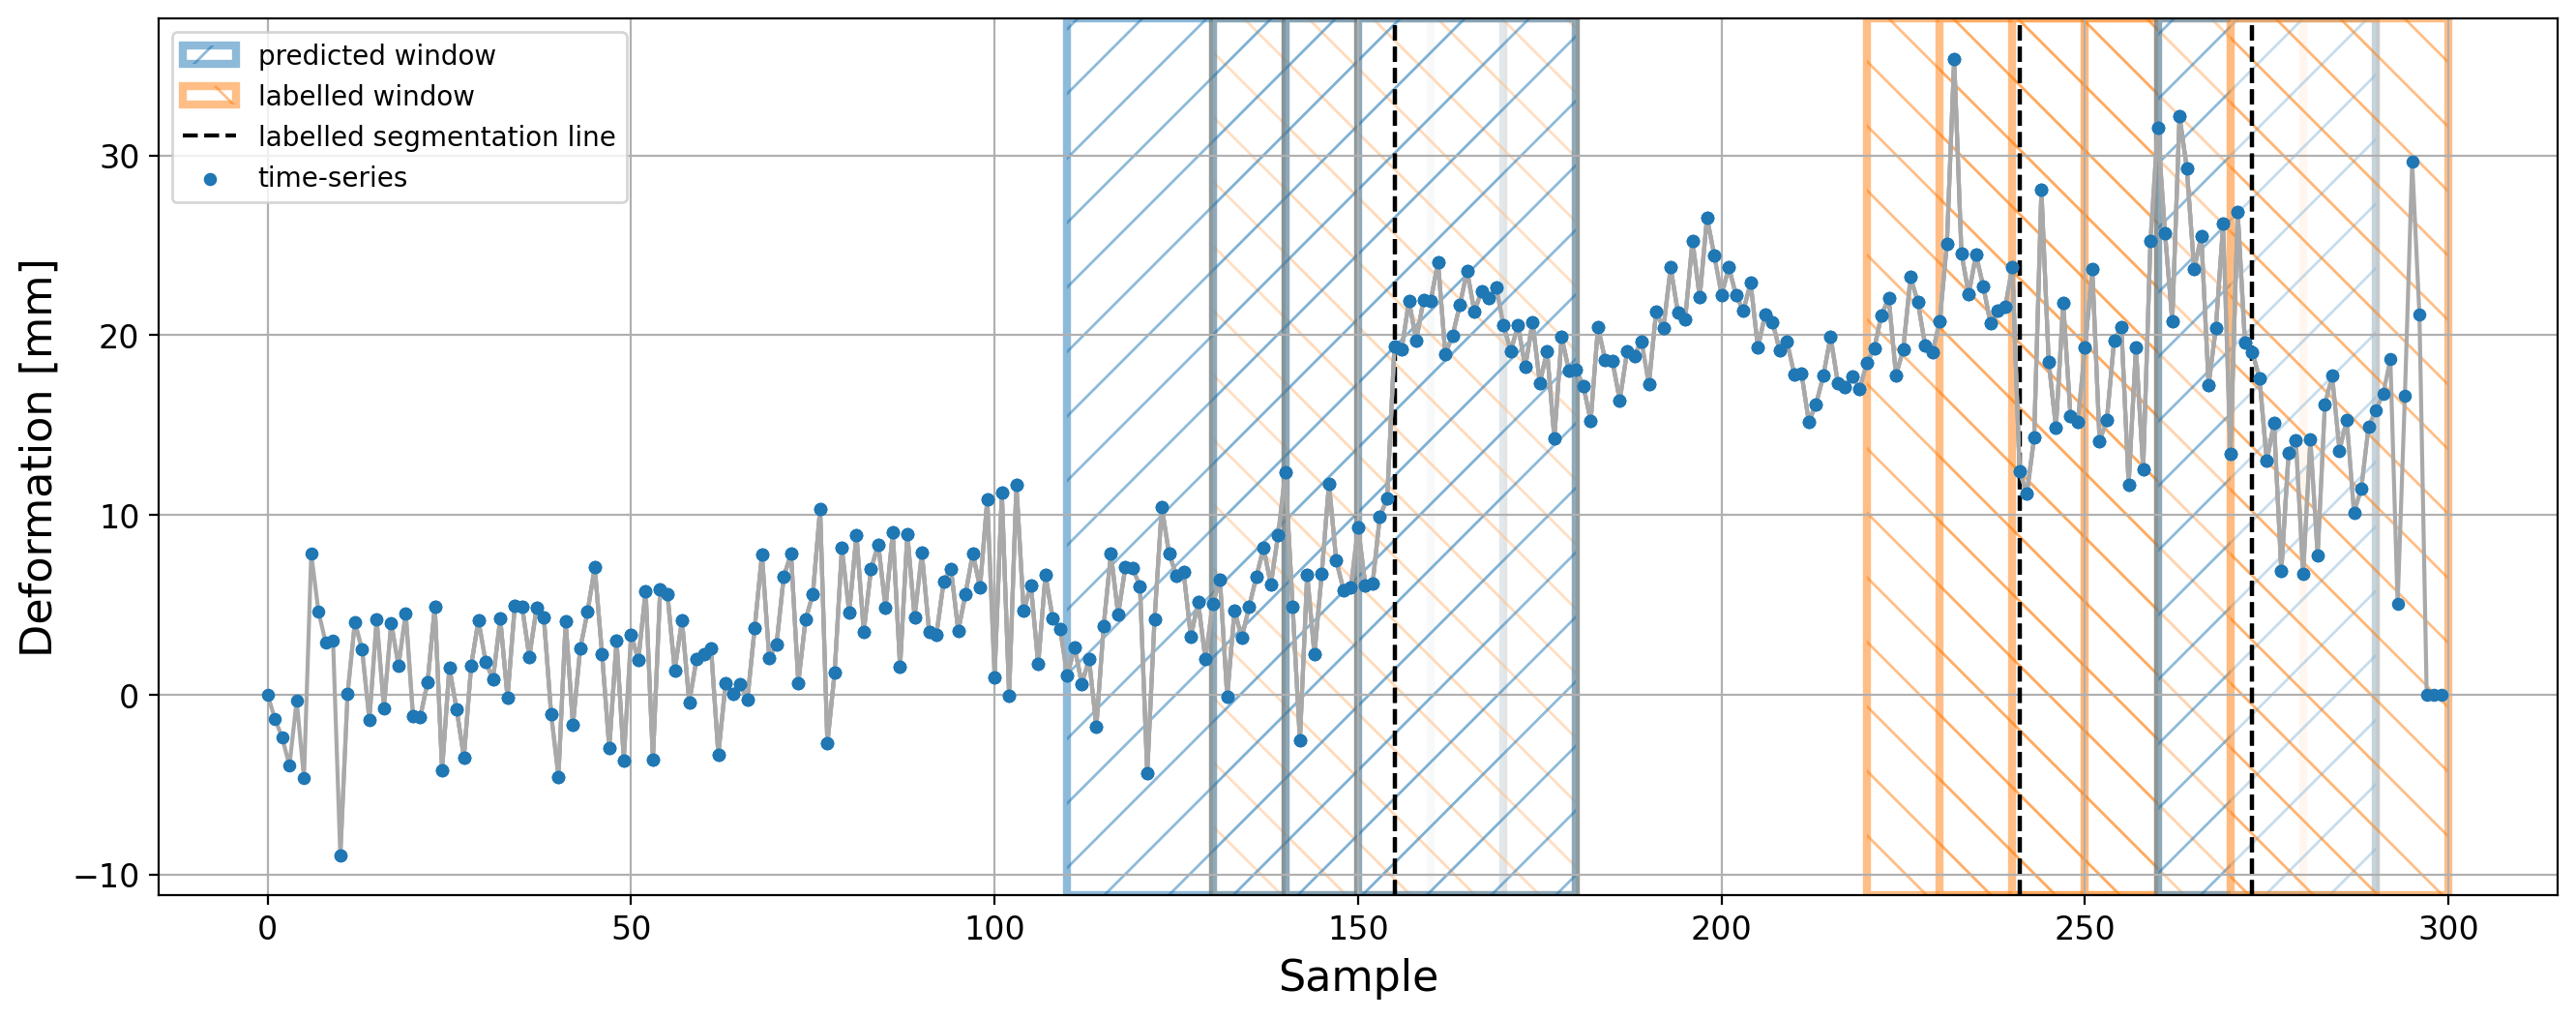

In [24]:
# ts_idx = next(ts_iter)
ts_idx = 118
print(ts_idx)
d = data[ts_idx]
dd = data_divided[ts_idx]
y = y_segm_divided[ts_idx]
y_all = y_segm_all_divided[ts_idx]
y_pred = y_val_pred_df[y_val_pred_df["ts_id"] == ts_idx]["label"]

fig = plt.figure(figsize=(16,6), dpi=200)
ax = plt.gca()
for w in range(num_of_windows):
    xs = w*shift
    xe = w*shift + window_len
    ax.plot(range(xs, xe), dd[w], c='darkgrey', zorder=3)
    tl = ax.scatter(range(xs, xe), dd[w], c='tab:blue', zorder=4, s=15, label="time-series")
    if y[w] == 1:
        gt_area = ax.axvspan(xs, xe, alpha=0.5, facecolor="white", edgecolor="tab:orange", hatch="\\", linewidth=3, label="labelled window")
    for x, val in enumerate(y_all[w]):
        if val == 1:
            gt_line = ax.axvline(xs+x, c="black", linestyle="--", label="labelled segmentation line")
    if y_pred.iloc[w] == 1:
        pred_area = ax.axvspan(xs, xe, alpha=0.5, facecolor="white", edgecolor="tab:blue", hatch="/", linewidth=3, label="predicted window")
plt.grid()
plt.xlabel("Sample", fontsize = 16)
plt.ylabel("Deformation [mm]", fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(handles=[pred_area, gt_area, gt_line, tl])
plt.show()

fig.tight_layout()
# fig.savefig(f'subs_example_fcnn_sf_118.jpg', bbox_inches="tight")

In [50]:
sf_train_ones = sf_train[sf_train["label"] == 1]
sf_train_zeros = sf_train[sf_train["label"] == 0].sample(n=len(X_train_ones), random_state=133)
sf_train_balanced = pd.concat([sf_train_zeros, sf_train_ones])
y_train_balanced = sf_train_balanced["label"]

sf_train_inp = sf_train_balanced.drop(columns=["ts_id", "win_id", "label"])
sf_test_inp = sf_test.drop(columns=["ts_id", "win_id", "label"])
sf_val_inp = sf_val.drop(columns=["ts_id", "win_id", "label"])

sf_real_inp = sf_real.drop(columns=["ts_id", "win_id", "label"])

In [65]:
model_sf = Sequential()
model_sf.add(Dense(units=64, input_shape=(45,)))
model_sf.add(Dense(units=32, activation='relu'))
model_sf.add(Dense(1, activation='sigmoid'))

sgd = optimizers.SGD(lr=0.001, decay=0.0, momentum=0.0, nesterov=False)
adam = optimizers.Adam(lr = 0.001)
model_sf.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
model_train_sf = model_sf.fit(sf_train_inp, y_train_balanced, 
                        batch_size=32, 
                        validation_split=0.2, 
                        epochs=100, 
                        callbacks=[tensorboard_callback, early_stopping_monitor],
                       )

Epoch 1/100
1314/1314 [==============================] - 2s 1ms/step - loss: 0.6544 - accuracy: 0.6326 - val_loss: 0.9063 - val_accuracy: 0.1470
Epoch 2/100
1314/1314 [==============================] - 1s 617us/step - loss: 0.6314 - accuracy: 0.6596 - val_loss: 0.9567 - val_accuracy: 0.1978
Epoch 3/100
1314/1314 [==============================] - 1s 638us/step - loss: 0.6233 - accuracy: 0.6687 - val_loss: 0.8822 - val_accuracy: 0.2638
Epoch 4/100
1314/1314 [==============================] - 1s 615us/step - loss: 0.6192 - accuracy: 0.6706 - val_loss: 0.9246 - val_accuracy: 0.2199
Epoch 5/100
1314/1314 [==============================] - 1s 619us/step - loss: 0.6137 - accuracy: 0.6746 - val_loss: 0.8107 - val_accuracy: 0.3126
Epoch 6/100
1314/1314 [==============================] - 1s 630us/step - loss: 0.6091 - accuracy: 0.6809 - val_loss: 0.9418 - val_accuracy: 0.2493
Epoch 7/100
1314/1314 [==============================] - 1s 637us/step - loss: 0.6055 - accuracy: 0.6850 - val_loss: 0.9

In [56]:
model_sf = keras.models.load_model("subs_fcn_model_sf_best2")

In [14]:
score = model_sf.evaluate(sf_test_inp, y_test, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

875/875 [==============================] - 1s 662us/step - loss: 0.4644 - accuracy: 0.8360
Test loss: 0.46444272994995117 / Test accuracy: 0.8360000252723694


recall: 0.4417989417989418
precision: 0.4667638838254952
f1-score: 0.45393842699285
[[42918  4388]
 [ 4853  3841]]


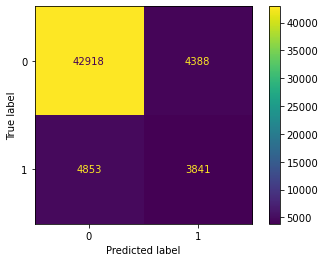

In [52]:
y_val_pred = (model_sf.predict(sf_val_inp) > 0.5).astype(int)

# Print f1, precision, and recall scores
print("recall:", recall_score(y_val, y_val_pred))
print("precision:", precision_score(y_val, y_val_pred))
print("f1-score:", f1_score(y_val, y_val_pred))

print(confusion_matrix(y_val, y_val_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred))
disp.plot()

recall: 0.46470185058259084
precision: 0.47490077048797574
f1-score: 0.4697459584295612
[[21374  2249]
 [ 2343  2034]]


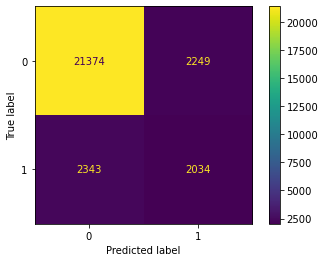

In [16]:
y_test_pred = (model_sf.predict(sf_test_inp) > 0.5).astype(int)

# Print f1, precision, and recall scores
print("recall:", recall_score(y_test, y_test_pred))
print("precision:", precision_score(y_test, y_test_pred))
print("f1-score:", f1_score(y_test, y_test_pred))

print(confusion_matrix(y_test, y_test_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred))
disp.plot()

recall: 0.1540880503144654
precision: 0.7205882352941176
f1-score: 0.2538860103626943
[[1735   19]
 [ 269   49]]


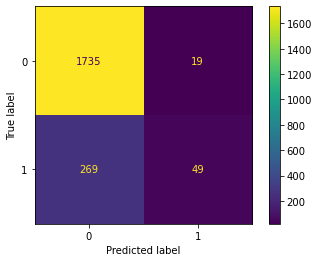

In [57]:
y_real_pred = (model_sf.predict(sf_real_inp) > 0.5).astype(int)

# Print f1, precision, and recall scores
print("recall:", recall_score(y_real, y_real_pred))
print("precision:", precision_score(y_real, y_real_pred))
print("f1-score:", f1_score(y_real, y_real_pred))

print(confusion_matrix(y_real, y_real_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_real, y_real_pred))
disp.plot()

## Real data

In [25]:
with open("raw_real_input_data_ans_seg.pkl", "rb") as file:
    raw_real_input = pickle.load(file)
    
data_real = raw_real_input["data"]
ans_seg_real = raw_real_input["ans_seg"]

y_segm_all= np.zeros((ans_seg_real.shape[0], num_of_windows, window_len))
for idx, ar in enumerate(ans_seg_real):
    for win in range(num_of_windows):
        inp = ar[shift*win: shift*win+window_len]
        y_segm_all[idx, win, 0:len(inp)] = inp
        
data_divided = np.zeros((data_real.shape[0], num_of_windows, window_len))
for idx, ar in enumerate(data_real):
    for win in range(num_of_windows):
        inp = ar[shift*win: shift*win+window_len]
        data_divided[idx, win, 0:len(inp)] = inp

In [26]:
y_real_pred_df = pd.concat([pd.DataFrame(y_real_pred, columns=["label"]), pd.DataFrame(idx_real, columns=["ts_id", "win_id"])], axis=1)

11 874


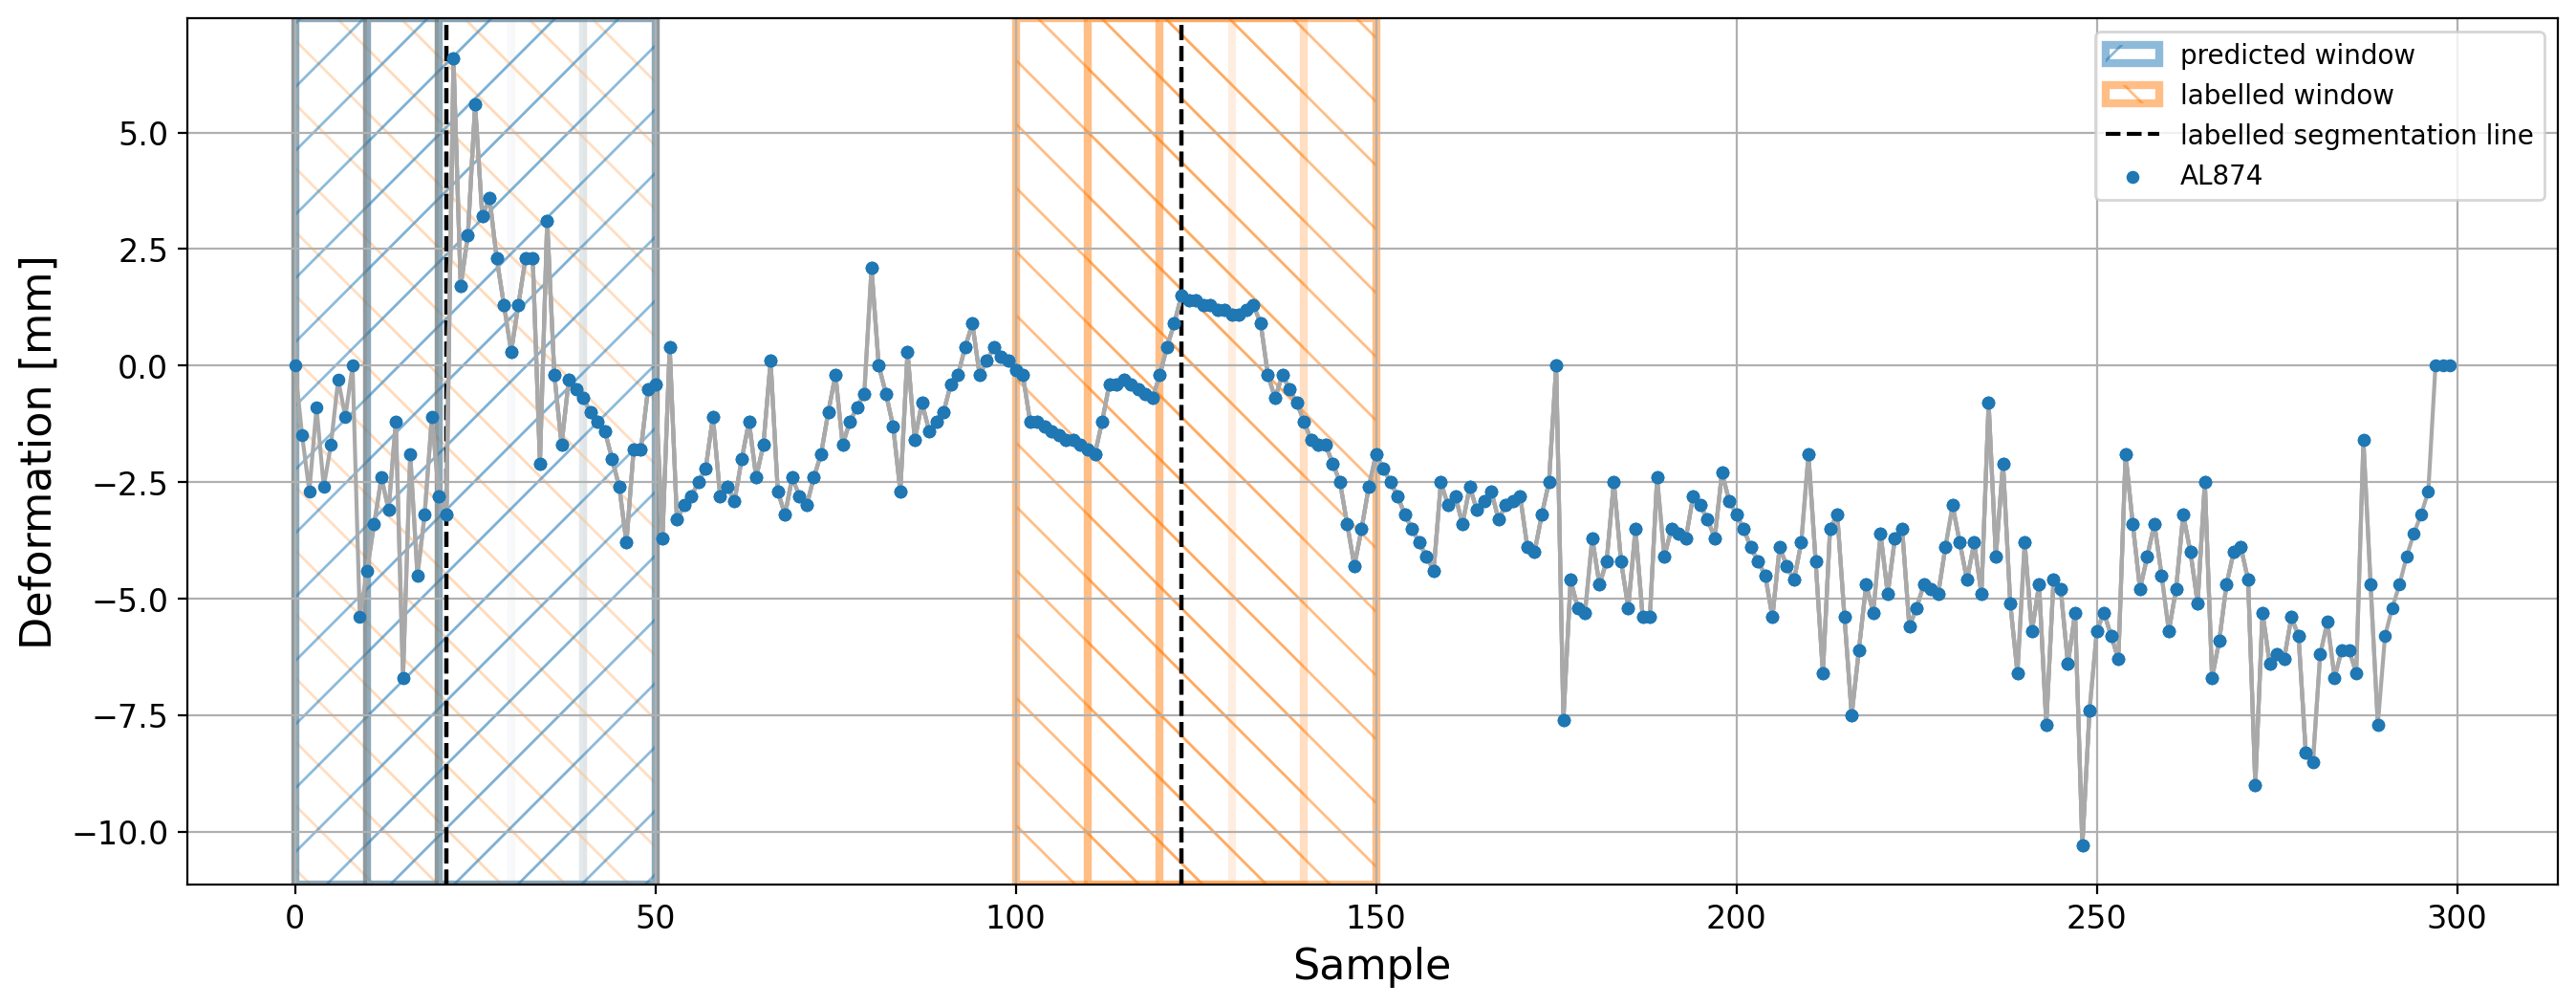

In [40]:
ts_num = 11 #next(ts_num_gen)
ts_idx = int(X_real.iloc[ts_num*28]["ts_id"])
print(ts_num, ts_idx)
d = data_real[ts_num]
dd = data_divided[ts_num]
y = (X_real[X_real["ts_id"] == ts_idx]["label"]).values
y_all = y_segm_all[ts_num]
y_pred = y_real_pred_df[y_real_pred_df["ts_id"] == ts_idx]["label"]

fig = plt.figure(figsize=(16,6), dpi=200)
ax = plt.gca()
for w in range(num_of_windows):
    xs = w*shift
    xe = w*shift + window_len
    ax.plot(range(xs, xe), dd[w], c='darkgrey', zorder=3)
    tl = ax.scatter(range(xs, xe), dd[w], c='tab:blue', zorder=4, s=15, label="AL874")
    if y[w] == 1:
#         ax.axvspan(xs, xe, alpha=0.1, hatch="\\", color='red')
        gt_area = ax.axvspan(xs, xe, alpha=0.5, facecolor="white", edgecolor="tab:orange", hatch="\\", linewidth=3, label="labelled window")
    for x, val in enumerate(y_all[w]):
        if val == 1:
            gt_line = ax.axvline(xs+x, c="black", linestyle="--", label="labelled segmentation line")
    if y_pred.iloc[w] == 1:
#         ax.axvspan(xs, xe, alpha=0.1, hatch="/", color='blue', linewidth=3)
        pred_area = ax.axvspan(xs, xe, alpha=0.5, facecolor="white", edgecolor="tab:blue", hatch="/", linewidth=3, label="predicted window")
plt.grid()
plt.xlabel("Sample", fontsize = 16)
plt.ylabel("Deformation [mm]", fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(handles=[pred_area, gt_area, gt_line, tl])
plt.show()

fig.tight_layout()
fig.savefig(f'subs_example_fcnn_real_al_11_874.jpg', bbox_inches="tight")

In [ ]:
with open("raw_real_input_data_ans_seg_ah.pkl", "rb") as file:
    raw_real_input = pickle.load(file)
    
data_real = raw_real_input["data"]
ans_seg_real = raw_real_input["ans_seg"]

y_segm_all= np.zeros((ans_seg_real.shape[0], num_of_windows, window_len))
for idx, ar in enumerate(ans_seg_real):
    for win in range(num_of_windows):
        inp = ar[shift*win: shift*win+window_len]
        y_segm_all[idx, win, 0:len(inp)] = inp

In [ ]:
y_real_ah_pred_df = pd.concat([pd.DataFrame(y_real_pred, columns=["label"]), pd.DataFrame(idx_real, columns=["ts_id", "win_id"])], axis=1)

In [ ]:
ts_num = 69
ts_idx = int(X_real_ah.iloc[ts_num*28]["ts_id"])
print(ts_idx)
d = data_real[ts_num]
dd = (X_real_ah_load[X_real_ah["ts_id"] == ts_idx].drop(columns=["ts_id", "win_id", "label"]).values)
y = (X_real_ah[X_real_ah["ts_id"] == ts_idx]["label"]).values
y_all = y_segm_all[ts_num]
y_pred = y_real_ah_pred_df[y_real_ah_pred_df["ts_id"] == ts_idx]["label"]

fig = plt.figure(figsize=(16,6), dpi=200)
ax = plt.gca()
for w in range(num_of_windows):
    xs = w*shift
    xe = w*shift + window_len
    ax.plot(range(xs, xe), dd[w], c='darkgrey', zorder=3)
    tl = ax.scatter(range(xs, xe), dd[w], c='tab:blue', zorder=4, s=15, label="time-series")
    if y[w] == 1:
#         ax.axvspan(xs, xe, alpha=0.1, hatch="\\", color='red')
        pred_area = ax.axvspan(xs, xe, alpha=0.5, facecolor="white", edgecolor="tab:orange", hatch="\\", linewidth=3, label="predicted window")
    for x, val in enumerate(y_all[w]):
        if val == 1:
            gt_line = ax.axvline(xs+x, c="black", linestyle="--", label="labelled segmentation line")
    if y_pred.iloc[w] == 1:
#         ax.axvspan(xs, xe, alpha=0.1, hatch="/", color='blue', linewidth=3)
        gt_area = ax.axvspan(xs, xe, alpha=0.5, facecolor="white", edgecolor="tab:blue", hatch="/", linewidth=3, label="labelled window")
plt.grid()
plt.xlabel("Sample", fontsize = 16)
plt.ylabel("Deformation [mm]", fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(handles=[gt_area, pred_area, gt_line, tl])
plt.show()

fig.tight_layout()
# fig.savefig(f'subs_example_cnn_01.jpg', bbox_inches="tight")